In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#LAB 3  - REDES GANs
Nombre: Ariel Rodrigo Colque Garcia


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

# Carga de los Datos (The Simpsons Characters Data)

In [ ]:
import torchvision
from torchvision import transforms

# Definir una transformación para convertir las imágenes a tensores y normalizarlas
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.CenterCrop(96),
    transforms.Resize(96),
])

# Crear el dataset a partir de la carpeta simpsom_dataset
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Data/simpsons_dataset", transform=transform)

# Mostrar el tamaño del dataset y las clases
print("Tamaño del dataset:", len(dataset))
print("Clases del dataset:", dataset.classes)

Tamaño del dataset: 7692
Clases del dataset: ['bart_simpson', 'homer_simpson', 'lisa_simpson', 'marge_simpson', 'ned_flanders']


In [ ]:
# Crear el DataLoader a partir del dataset, Permite usar múltiples procesos para cargar los datos en paralelo
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

# Obtener un lote de imágenes y etiquetas del DataLoader
images, labels = next(iter(dataloader))
images.shape, labels.shape, images.max(), images.min()

(torch.Size([64, 3, 96, 96]), torch.Size([64]), tensor(1.), tensor(-1.))

# Visualizacion de las imagenes.

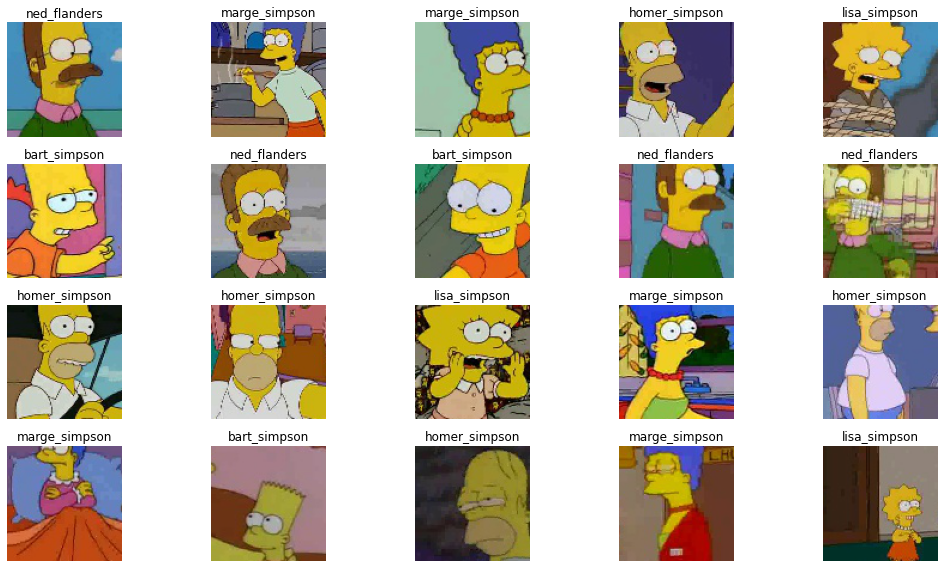

In [ ]:
import matplotlib.pyplot as plt
# Desnormalizar las imágenes para mostrarlas correctamente
images = images * 0.5 + 0.5

# Crear una figura con 20 subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 8))

# Iterar sobre los subplots y mostrar una imagen y su clase en cada uno
for i, ax in enumerate(axes.flat):
    # Comprobar si el índice i es menor que el número de imágenes en el lote
    if i < images.shape[0]:
        # Mostrar la imagen
        ax.imshow(images[i].permute(1, 2, 0))
        # Mostrar la clase
        ax.set_title(dataset.classes[labels[i]])
    # Quitar los ejes
    ax.axis("off")

# Ajustar el espacio entre los subplots
plt.tight_layout()
# Mostrar la figura
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# GENERADOR

In [ ]:
import torch.nn as nn

# Definir el tamaño del vector latente
nz = 100

# Definir la clase del generador DCGAN
class DCGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Primera capa: recibe un vector latente de tamaño nz y lo transforma en una imagen de 4x4x256
        self.inp = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256), # estabiliza el aprendizaje y reduce el sobreajuste
            nn.ReLU(True)
        )
        # Capas restantes: reciben una imagen y la transforman en otra de mayor resolución
        self.main = nn.Sequential(
            # Segunda capa: recibe una imagen de 4x4x256 y la transforma en una imagen de 8x8x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Tercera capa: recibe una imagen de 8x8x128 y la transforma en una imagen de 16x16x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Cuarta capa: recibe una imagen de 16x16x64 y la transforma en una imagen de 32x32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Quinta capa: recibe una imagen de 32x32x32 y la transforma en una imagen de 96x96x3
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=3, padding=1, bias=False),
            nn.Tanh() #0 y 1.
        )

    def forward(self, x):
        # Recibe un vector latente de tamaño nz
        x = x.view(-1, nz, 1, 1)
        # Aplica la primera capa
        x = self.inp(x)
        # Aplica las capas restantes
        x = self.main(x)
        # Devuelve una imagen de tamaño 96x96x3
        x = x.view(x.size(0), 3, 96, 96)
        return x

In [ ]:
generator = DCGANGenerator()

output = generator(torch.randn(16, 100))
print(output.shape)
generator = generator.to(device)

torch.Size([16, 3, 96, 96])


#Discriminador

In [ ]:
import torch.nn as nn

# Definir la clase del discriminador DCGAN
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Capas principales: reciben una imagen y la transforman en otra de menor resolución
        self.main = nn.Sequential(
            # Primera capa: recibe una imagen de 96x96x3 y la transforma en una imagen de 48x48x32
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Segunda capa: recibe una imagen de 48x48x32 y la transforma en una imagen de 24x24x64
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64), #
            nn.LeakyReLU(0.2, inplace=True),
            # Tercera capa: recibe una imagen de 24x24x64 y la transforma en una imagen de 12x12x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Cuarta capa: recibe una imagen de 12x12x128 y la transforma en una imagen de 6x6x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Capa de salida: recibe un vector y lo transforma en un valor escalar entre 0 y 1
        self.out = nn.Sequential(
            # Cambiar el tamaño del vector de entrada a 256 * 6 * 6
            nn.Linear(256 * 6 * 6, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Recibe una imagen de tamaño 96x96x3
        x = self.main(x)
        # Cambia el tamaño del vector a 256 * 6 * 6
        x = x.view(x.size(0), -1)
        # Aplica la capa de salida
        x = self.out(x)
        # Devuelve un valor escalar entre 0 y 1
        return x

In [ ]:
discriminator = DCGANDiscriminator()
output = discriminator(torch.randn(16, 3, 96, 96))
print(output.shape)
discriminator = discriminator.to(device)

torch.Size([16, 1])


# ENTRENAMIENTO

In [ ]:
def train_gan(generator, discriminator, dataloader, num_epochs=100, checkpoint_path=None):

    # función de pérdida binaria cruzada
    criterion = nn.BCELoss()

    # optimizadores para el generador y el discriminador
    optimizer_g = torch.optim.Adam(generator.parameters(), lr= 0.0001)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr= 0.0001)

    # etiquetas verdaderas y falsas para el discriminador
    real_label = 1
    fake_label = 0

    # lista para almacenar la pérdida del generador y el discriminador
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # tamaño del lote
            batch_size = imgs.size(0)

            # etiquetas verdaderas y falsas para el discriminador
            real_labels = torch.full((batch_size,), real_label, device=device).float()
            fake_labels = torch.full((batch_size,), fake_label, device=device).float()

            # entrenamiento del discriminador con imágenes reales
            discriminator.zero_grad()
            real_output = discriminator(imgs.to(device)).view(-1)
            d_loss_real = criterion(real_output, real_labels)

            # entrenamiento del discriminador con imágenes falsas generadas por el generador
            noise = torch.randn(batch_size, 100, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs.detach()).view(-1)
            d_loss_fake = criterion(fake_output, fake_labels)

            # actualización de los pesos del discriminador
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # entrenamiento del generador para engañar al discriminador
            generator.zero_grad()
            fake_output = discriminator(fake_imgs).view(-1)
            g_loss = criterion(fake_output, real_labels)

            # actualización de los pesos del generador
            g_loss.backward()
            optimizer_g.step()

        # almacenamiento de la pérdida del generador y el discriminador en cada época
        hist['g_loss'].append(g_loss.item())    
        hist['d_loss'].append(d_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
        # Guardar checkpoint
        if checkpoint_path is not None and (epoch+1) % 10 == 0:
            torch.save({
                'epoch': epoch+1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'generator_optimizer_state_dict': optimizer_g.state_dict(),
                'discriminator_optimizer_state_dict': optimizer_d.state_dict(),
                'generator_loss': g_loss.item(),
                'discriminator_loss': d_loss.item(),
            }, checkpoint_path)
    return hist

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Data/Checkpoint/entrenamiento1.tar'
hist = train_gan(generator, discriminator, dataloader, num_epochs=50, checkpoint_path=checkpoint_path)

KeyboardInterrupt: ignored

# GRAFICO DE PERDIDAS (loss)

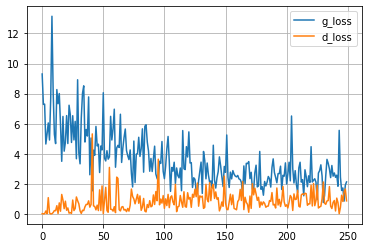

In [ ]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

# GENERACION DE IMAGENES

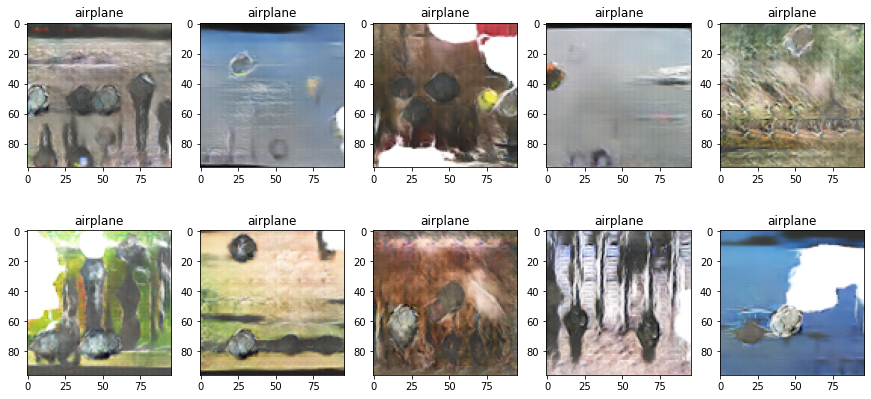

In [ ]:
# generamos las imagenes
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size), device=device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,7))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].permute(1, 2, 0).cpu()
      img = (img - img.min()) / (img.max() - img.min())  # normalizar en [0, 1]
      class_idx = torch.argmax(discriminator(generated_images[i].unsqueeze(0).to(device)))
      _ax.set_title(classes[class_idx])
      _ax.imshow(img.permute(2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
      i+=1
  plt.show()
